In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind,  chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [2]:
sentiment = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

In [8]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['date'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')

trades['date'] = trades['date'].dt.date
sentiment['date'] = sentiment['date'].dt.date

merged = pd.merge(trades, sentiment[['date', 'classification']], on='date', how='left')

In [10]:
print(merged.isnull().sum())
print(merged['classification'].value_counts())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
classification      6
dtype: int64
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


In [16]:
merged['sentiment'] = merged['classification'].apply(lambda x: 'Greed' if 'Greed' in str(x) else 'Fear')

print(merged.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'classification', 'sentiment', 'Trade_Outcome']


In [17]:
merged['Trade_Outcome'] = merged['Closed PnL'].apply(lambda x: 'Profit' if x > 0 else ('Loss' if x < 0 else 'BreakEven'))

merged['Side_Label'] = merged['Side'].map({'BUY':1, 'SELL':0})

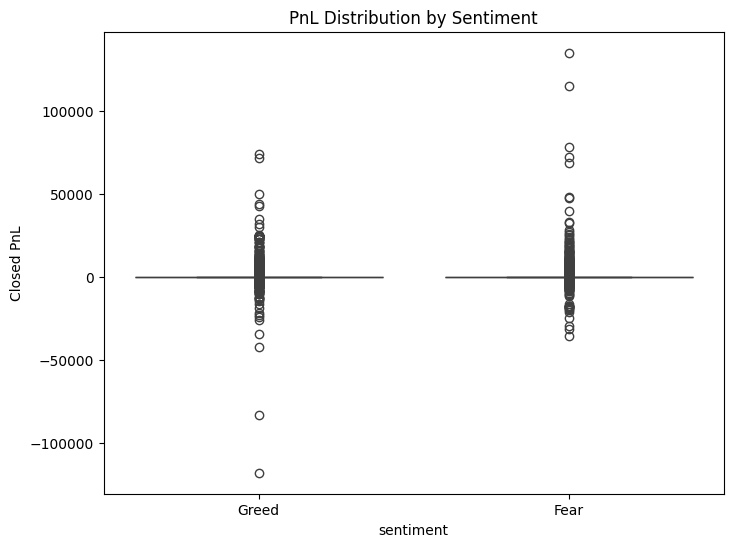

In [22]:
plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment', y='Closed PnL', data=merged)
plt.title('PnL Distribution by Sentiment')
plt.show()


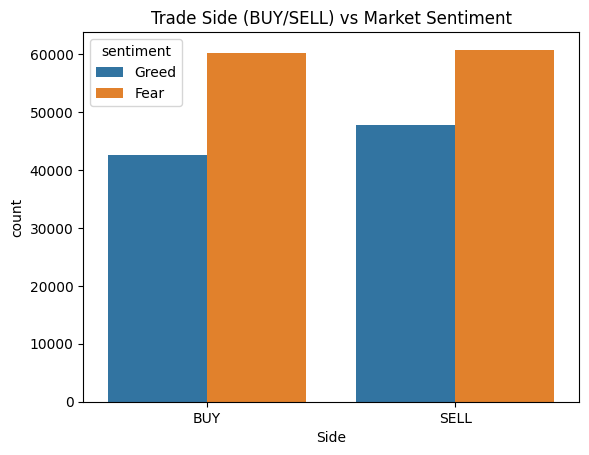

In [24]:
sns.countplot(x='Side', hue='sentiment', data=merged)
plt.title('Trade Side (BUY/SELL) vs Market Sentiment')
plt.show()


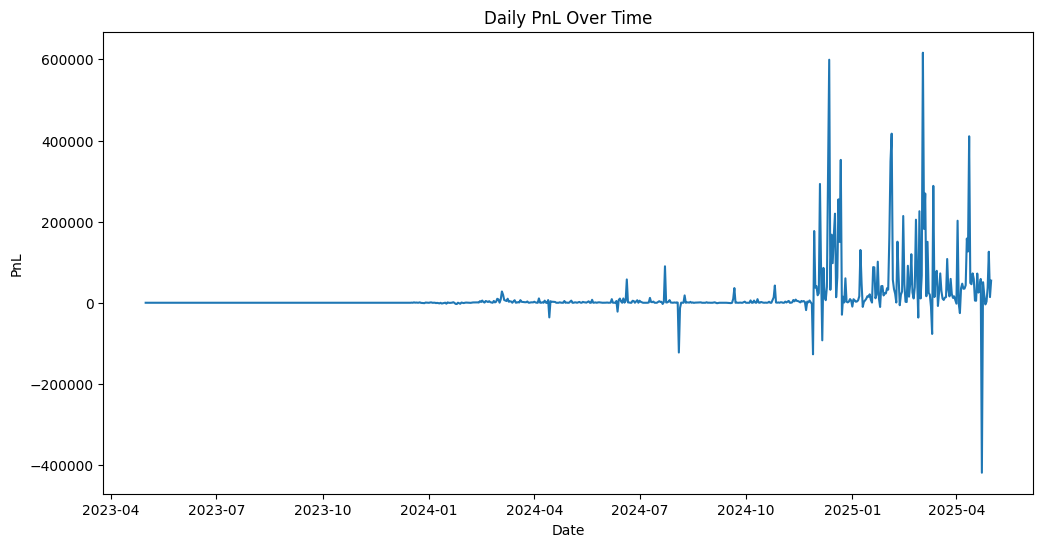

In [25]:
daily_pnl = merged.groupby('date')['Closed PnL'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(daily_pnl['date'], daily_pnl['Closed PnL'])
plt.title('Daily PnL Over Time')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()


In [26]:
fear_pnl = merged[merged['sentiment']=='Fear']['Closed PnL']
greed_pnl = merged[merged['sentiment']=='Greed']['Closed PnL']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print(f"T-test: t={t_stat}, p={p_value}")
if p_value < 0.05:
    print("✅ Significant difference in PnL between Fear and Greed days.")
else:
    print("❌ No significant difference.")


T-test: t=-2.182337102717786, p=0.02908593749862571
✅ Significant difference in PnL between Fear and Greed days.


In [27]:
contingency = pd.crosstab(merged['Side'], merged['sentiment'])

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square test: chi2={chi2}, p={p}")
if p < 0.05:
    print("✅ Trade direction is dependent on sentiment.")
else:
    print("❌ No significant relation between trade direction and sentiment.")


Chi-square test: chi2=148.4219002961485, p=3.8362470139082764e-34
✅ Trade direction is dependent on sentiment.


In [30]:
# Prepare data
merged['Sentiment_Label'] = merged['sentiment'].map({'Fear':0, 'Greed':1})

X = merged[['Sentiment_Label', 'Side_Label', 'Size USD', 'Execution Price']]
y = (merged['Closed PnL'] > 0).astype(int)  # 1=Profit, 0=Not Profit

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8758679459664184
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     37218
           1       0.86      0.84      0.85     26150

    accuracy                           0.88     63368
   macro avg       0.87      0.87      0.87     63368
weighted avg       0.88      0.88      0.88     63368

